## 读取VOC2007数据

In [1]:
import os
#import torch
#import torch.nn as nn
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import ToTensor
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
import numpy as np
import cv2

class_dict={}
class_index=0

#定义图像预处理（[0,1]、归一化、resize 256*256等） 
def read_image(x):
    x=cv2.imread(x)
    x=cv2.resize(x,(256,256))
    x=np.array(x,dtype=np.float32)
    x=np.transpose(x,(2,0,1))
    x/=255
    return x
#定义标签的预处理 （resize等）
def read_mask(x):
    global class_index
    x=Image.open(x)
    x=x.resize((256,256),Image.ANTIALIAS)
    x=np.array(x)
    for i in x:
        for j in range(len(i)):
            if i[j]==255:
                i[j]=0
            if i[j] not in class_dict:
                class_dict[i[j]]=i[j]
                class_index+=1
    return x
# 定义数据读取函数load_data，按照test_size给的比例，将数据分为训练集和测试集
def load_data(image_folder, mask_folder, test_size=0.2):
    image_paths = [os.path.join(image_folder, img) for img in sorted(os.listdir(image_folder))]
    mask_paths = [os.path.join(mask_folder, msk) for msk in sorted(os.listdir(mask_folder))]
    # 读取训练集和测试集数据
    train_images_paths, test_images_paths, train_masks_paths, test_masks_paths = train_test_split(
            image_paths, mask_paths, test_size=test_size, random_state=1
        )
    
    train_images = []
    train_masks  =[]
    test_images =[]
    test_masks =[]   
    #读取训练集图像和标签
    for idx_tr in train_images_paths:
        train_images.append(read_image(idx_tr))
    for idx_tr in train_masks_paths:
        train_masks.append(read_mask(idx_tr))
    #读取测试集图像和标签
    for idx_te in test_images_paths:
        test_images.append(read_image(idx_te))
    for idx_te in test_masks_paths:
        test_masks.append(read_mask(idx_te))
    train_images = np.array(train_images)
    train_masks  =np.array(train_masks)
    test_images =np.array(test_images)
    test_masks =np.array(test_masks)
    
    return train_images, train_masks, test_images,  test_masks

# 文件夹路径
image_folder = './VOC2007/JPEGImages/'
mask_folder = './VOC2007/SegmentationClass/'

[train_img,train_lb,test_img,test_lb] = load_data(image_folder, mask_folder)

# 打印查看数据集格式
print('训练集图像格式为:', train_img.shape, '训练集标签格式为:', train_lb.shape)
print('测试集图像格式为:', test_img.shape, '测试集标签格式为:', test_lb.shape)
print(class_index)

C:\Users\15432\AppData\Local\Temp\ipykernel_8952\3911558664.py:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  x=x.resize((256,256),Image.ANTIALIAS)


训练集图像格式为: (337, 3, 256, 256) 训练集标签格式为: (337, 256, 256)
测试集图像格式为: (85, 3, 256, 256) 测试集标签格式为: (85, 256, 256)
21


In [ ]:
np.savez("dataset",train_img,train_lb,test_img,test_lb)
print("saved")

In [ ]:
x=train_lb
tmp=np.eye(21)[train_lb]
tmp=np.transpose(tmp,(0,3,1,2))
print(tmp.shape)

In [2]:
import torch
from torch import nn
import numpy as np
import os
import cv2
def get_hot(label):
    hot=np.eye(21)[label]
    hot=np.transpose(hot,(0,3,1,2))
    return hot
tmp=np.load("dataset.npz")
train_img=tmp["arr_0"]
train_lb=tmp["arr_1"]
test_img=tmp["arr_2"]
test_lb=tmp["arr_3"]

index = np.random.permutation(train_img.shape[0])
train_img=train_img[index]
train_lb=train_lb[index]
index = np.random.permutation(test_img.shape[0])
test_img=test_img[index]
test_lb=test_lb[index]

hot_train_lb=get_hot(train_lb)
hot_test_lb=get_hot(test_lb)
print('训练集图像格式为:', train_img.shape, '训练集标签格式为:', train_lb.shape,'热编码训练集标签格式为:', hot_train_lb.shape)
print('测试集图像格式为:', test_img.shape, '测试集标签格式为:', test_lb.shape,'热编码测试集标签格式为:', hot_test_lb.shape)

训练集图像格式为: (337, 3, 256, 256) 训练集标签格式为: (337, 256, 256) 热编码训练集标签格式为: (337, 21, 256, 256)
测试集图像格式为: (85, 3, 256, 256) 测试集标签格式为: (85, 256, 256) 热编码测试集标签格式为: (85, 21, 256, 256)


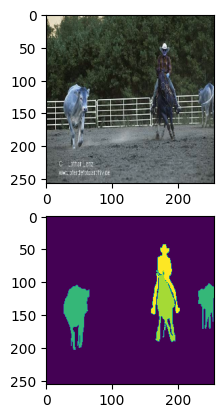

In [2]:
from matplotlib import pyplot as plt
num=1
x=train_img[num]
y=train_lb[num]
x=np.transpose(x,(1,2,0))
#print(train_lb[123])
plt.subplot(2,1,1)
plt.imshow(x)
plt.subplot(2,1,2)
plt.imshow(y)
#plt.show()

## 搭建Unet网络

In [3]:
# define UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        # Define the encoder layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        # Define the decoder layers
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(64)
        self.conv8 = nn.Conv2d(64,21, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        x1 = nn.functional.relu(self.bn1(self.conv1(x)))
        x2 = nn.functional.max_pool2d(x1, kernel_size=2, stride=2)
        x3 = nn.functional.relu(self.bn2(self.conv2(x2)))
        x4 = nn.functional.max_pool2d(x3, kernel_size=2, stride=2)
        x5 = nn.functional.relu(self.bn3(self.conv3(x4)))
        x6 = nn.functional.max_pool2d(x5, kernel_size=2, stride=2)
        x7 = nn.functional.relu(self.bn4(self.conv4(x6)))
        # Decoder
        x8 = self.upconv1(x7)
        x8 = torch.cat([x8, x5], dim=1)
        x9 = nn.functional.relu(self.bn5(self.conv5(x8)))
        x10 = self.upconv2(x9)
        x10 = torch.cat([x10, x3], dim=1)
        x11 = nn.functional.relu(self.bn6(self.conv6(x10)))
        x12 = self.upconv3(x11)
        x12 = torch.cat([x12, x1], dim=1)
        x13 = nn.functional.relu(self.bn7(self.conv7(x12)))
        x14 = self.conv8(x13)
        return x14


model=UNet()



## 训练Unet网络

In [25]:
#超参数
batch_size = 32
epochs = 2
learning_rate = 1e-3
model=UNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 设置 device，是否使用GPU（适用于Mac）
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = model.to(device)
loss_fn = loss_fn.to(device)
best_loss = float('inf')

train_loss_history = []
test_loss_history = []

model.train()

for epoch in range(epochs):
    train_mean_loss = 0.0
    correct =0.
    batch_num=int(train_img.shape[0]/batch_size)
    for batch in range(batch_num):
        X=train_img[batch*batch_size:(batch+1)*batch_size,]
        y=hot_train_lb[batch*batch_size:(batch+1)*batch_size,:]
        X=torch.tensor(X, dtype=torch.float32).to(device)
        y=torch.tensor(y, dtype=torch.float32).to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).mean().item()
        train_mean_loss+= loss.item()

    train_mean_loss /= batch_num
    correct /= batch_num
    
    print(f" Epoch:{epoch+1}, loss: {train_mean_loss:>8f},  Accuracy: {(100*correct):>0.1f}%")
    
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    X=torch.tensor(test_img, dtype=torch.float32).to(device)
    y=torch.tensor(hot_test_lb, dtype=torch.float32).to(device)
    pred = model(X)
    test_loss = np.mean(loss_fn(pred, y).item())
    correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).mean().item()

print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f} \n")


    


KeyboardInterrupt: 

## 在训练过程中添加测试过程。

### 每个epoch结束后，进行测试，给出相应的测试损失和精度，如果精度高于之前的epoch，则将本次epoch的参数保存。

In [3]:
min_acc=0
def test(model):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    loss_fn.to(device)
    test_loss, correct = 0, 0
    with torch.no_grad():
        X=torch.tensor(test_img, dtype=torch.float32).to(device)
        y=torch.tensor(hot_test_lb, dtype=torch.float32).to(device)
        pred = model(X)
        test_loss = np.mean(loss_fn(pred, y).item())
        correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).mean().item()
        print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f} ")
    model.train()
    return correct
def auto_save(model):
    global min_acc
    acc=test(model)
    if acc>min_acc:
        min_acc=acc
        torch.save(model,"Unet.pt")
        print("saved")
    

In [10]:
#超参数
batch_size = 32
epochs = 50
learning_rate = 1e-3
model=UNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 设置 device，是否使用GPU（适用于Mac）
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = model.to(device)
loss_fn = loss_fn.to(device)
best_loss = float('inf')

train_loss_history = []
test_loss_history = []

model.train()

for epoch in range(epochs):
    train_mean_loss = 0.0
    correct =0.
    batch_num=int(train_img.shape[0]/batch_size)
    for batch in range(batch_num):
        
        X=train_img[batch*batch_size:(batch+1)*batch_size,]
        y=hot_train_lb[batch*batch_size:(batch+1)*batch_size,:]
        X=torch.tensor(X, dtype=torch.float32).to(device)
        y=torch.tensor(y, dtype=torch.float32).to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).mean().item()
        train_mean_loss+= loss.item()
        
    train_mean_loss /= batch_num
    correct /= batch_num
    
    print(f" Epoch:{epoch+1}, loss: {train_mean_loss:>8f},  Accuracy: {(100*correct):>0.1f}%")
    auto_save(model)

 Epoch:1, loss: 2.543393,  Accuracy: 43.7%
Test Accuracy: 73.7%, Test Avg loss: 2.431704 
 Epoch:2, loss: 2.053799,  Accuracy: 67.8%
Test Accuracy: 73.5%, Test Avg loss: 1.616915 
 Epoch:3, loss: 1.723592,  Accuracy: 71.4%
Test Accuracy: 73.0%, Test Avg loss: 1.598845 
 Epoch:4, loss: 1.492075,  Accuracy: 73.7%
Test Accuracy: 71.9%, Test Avg loss: 1.544231 
 Epoch:5, loss: 1.337998,  Accuracy: 74.3%
Test Accuracy: 68.7%, Test Avg loss: 1.562725 
 Epoch:6, loss: 1.248887,  Accuracy: 74.4%
Test Accuracy: 70.9%, Test Avg loss: 1.410168 
 Epoch:7, loss: 1.200934,  Accuracy: 74.2%
Test Accuracy: 73.2%, Test Avg loss: 1.333207 
 Epoch:8, loss: 1.168823,  Accuracy: 74.2%
Test Accuracy: 66.0%, Test Avg loss: 1.434489 
 Epoch:9, loss: 1.149901,  Accuracy: 74.7%
Test Accuracy: 71.7%, Test Avg loss: 1.309959 
 Epoch:10, loss: 1.128929,  Accuracy: 74.8%
Test Accuracy: 74.1%, Test Avg loss: 1.226941 
 Epoch:11, loss: 1.114977,  Accuracy: 74.6%
Test Accuracy: 71.5%, Test Avg loss: 1.229502 
 Epoch:1

KeyboardInterrupt: 

### 画出训练模型在测试集部分图像上的分割结果以及Ground truth

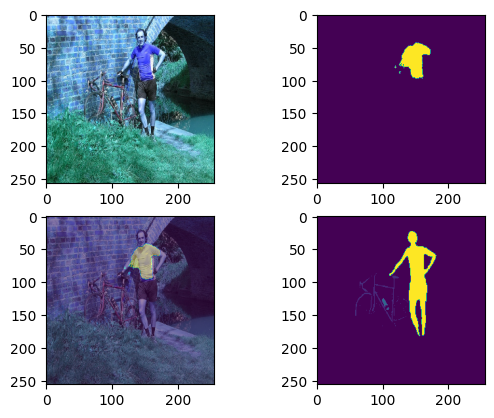

In [22]:
import matplotlib.pyplot as plt
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model=torch.load("Unet.pt")
model = model.to(device)
def infer(x):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        X=torch.tensor(x, dtype=torch.float32).to(device)
        pred = model(X)
        pred=np.array(pred.to("cpu"))
        pred=np.transpose(pred,(0,2,3,1))
        pred=np.argmax(pred,axis=3)
    model.train()
    return pred

#test(model)
num=17
x=test_img[num:num+1]

y=infer(x)
z=test_lb[num:num+1]
z=np.transpose(z,(1,2,0))

x=x[0]
x=np.transpose(x,(1,2,0))
y=y[0]
plt.subplot(221)
plt.imshow(x)
 
plt.subplot(222)
plt.imshow(y)
 
plt.subplot(223)
plt.imshow(x)
plt.imshow(y,alpha=0.5)

plt.subplot(224)
plt.imshow(z)
#plt.show()

Test Accuracy: 75.0%, Test Avg loss: 1.270900 


0.7499579787254333

## （选作）将Unet网络结构的Encoder部分变成Resnet的结构，并使用Resnet参数，对训练和测试结果进行分析。

In [2]:
import torchvision.models as models
# define UNet model
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet=models.resnet18(weights='IMAGENET1K_V1')
        # Define the encoder layers
        # Define the decoder layers
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.upconv2 = nn.ConvTranspose2d(256,128, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(64)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv5 = nn.ConvTranspose2d(160, 64, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(64,21, kernel_size=1, stride=1)

    def forward(self, x):
        # Encoder
        
        x1 = self.resnet.relu(self.resnet.bn1((self.resnet.conv1(x))))
        x2 = self.resnet.maxpool(x1)
        x3 = self.resnet.layer1(x2)
        x4 = self.resnet.layer2(x3)
        x5 = self.resnet.layer3(x4)
        x6= self.resnet.layer4(x5)
        # Decoder
        x8 = self.upconv1(x6)
        x8 = torch.cat([x8, x5], dim=1)
        x9 = nn.functional.relu(self.bn5(self.conv5(x8)))
        x10 = self.upconv2(x9)
        x10 = torch.cat([x10, x4], dim=1)
        x11 = nn.functional.relu(self.bn6(self.conv6(x10)))
        x12 = self.upconv3(x11)
        x12 = torch.cat([x12, x3], dim=1)
        x13 = nn.functional.relu(self.bn7(self.conv7(x12)))
        x14 = self.upconv4(x13)
        x15 = torch.cat([x14, x1], dim=1)
        x15 = torch.cat([x15, x1], dim=1)
        x15=self.upconv5(x15)
        
        x16 = self.conv8(x15)
        return x16
#print(UNet().resnet)

In [3]:
min_acc=0
def test(model):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    loss_fn.to(device)
    test_loss, correct = 0, 0
    with torch.no_grad():
        X=torch.tensor(test_img, dtype=torch.float32).to(device)
        y=torch.tensor(hot_test_lb, dtype=torch.float32).to(device)
        pred = model(X)
        test_loss = np.mean(loss_fn(pred, y).item())
        correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).mean().item()
        print(f"Test Accuracy: {(100*correct):>0.1f}%, Test Avg loss: {test_loss:>8f} ")
    model.train()
    return correct
def auto_save(model):
    global min_acc
    acc=test(model)
    if acc>min_acc:
        min_acc=acc
        torch.save(model,"Unet+res.pt")
        print("saved")
    

In [5]:
#超参数
batch_size = 32
epochs = 50
learning_rate = 1e-3
model=UNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 设置 device，是否使用GPU（适用于Mac）
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = model.to(device)
loss_fn = loss_fn.to(device)
best_loss = float('inf')

train_loss_history = []
test_loss_history = []

model.train()

for epoch in range(epochs):
    train_mean_loss = 0.0
    correct =0.
    batch_num=int(train_img.shape[0]/batch_size)
    for batch in range(batch_num):
        X=train_img[batch*batch_size:(batch+1)*batch_size,]
        y=hot_train_lb[batch*batch_size:(batch+1)*batch_size,:]
        X=torch.tensor(X, dtype=torch.float32).to(device)
        y=torch.tensor(y, dtype=torch.float32).to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).mean().item()
        train_mean_loss+= loss.item()
        
    train_mean_loss /= batch_num
    correct /= batch_num
    
    print(f" Epoch:{epoch+1}, loss: {train_mean_loss:>8f},  Accuracy: {(100*correct):>0.1f}%")
    auto_save(model)

 Epoch:1, loss: 2.407243,  Accuracy: 63.3%
Test Accuracy: 74.1%, Test Avg loss: 1.839076 
 Epoch:2, loss: 1.297387,  Accuracy: 74.0%
Test Accuracy: 74.1%, Test Avg loss: 1.191606 
 Epoch:3, loss: 1.162871,  Accuracy: 74.0%
Test Accuracy: 74.1%, Test Avg loss: 1.231342 
 Epoch:4, loss: 1.095698,  Accuracy: 74.0%
Test Accuracy: 73.4%, Test Avg loss: 1.361804 
 Epoch:5, loss: 1.030831,  Accuracy: 74.0%
Test Accuracy: 73.1%, Test Avg loss: 1.359479 
 Epoch:6, loss: 0.999567,  Accuracy: 74.0%
Test Accuracy: 74.1%, Test Avg loss: 1.213555 
saved
 Epoch:7, loss: 0.943483,  Accuracy: 74.2%
Test Accuracy: 75.2%, Test Avg loss: 1.160633 
saved
 Epoch:8, loss: 0.907391,  Accuracy: 75.0%
Test Accuracy: 74.6%, Test Avg loss: 1.203798 
 Epoch:9, loss: 0.886826,  Accuracy: 76.1%
Test Accuracy: 75.3%, Test Avg loss: 1.216435 
saved
 Epoch:10, loss: 0.856450,  Accuracy: 77.0%
Test Accuracy: 75.0%, Test Avg loss: 1.258377 
 Epoch:11, loss: 0.842561,  Accuracy: 77.6%
Test Accuracy: 75.2%, Test Avg loss: 

KeyboardInterrupt: 